# Custom Datasets

We've use some datasets with PyTorch before

but how do you get your own data into PyTorch?

One of the ways to do so its via: Custom datasets.

## 0. Importing PyTorch and setting device agnostic code

In [71]:
import torch
from torch import nn

torch.__version__

'2.4.1'

In [72]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

our dataset is a subset of Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class(750 training,250 testing) 

our dataset starts with 3 classes of food and only 10% of the images(~75 training, 25 testing)

Why do this?

when starting ml projects, do on small scale and increase when necessary

the whole point is to speed up how fast you can experiment

In [73]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


## 2. Becoming one with the data (data preperation and data exploration)

In [74]:
import os
def walk_through_dir(dir_path):
    """Walk through directory paths returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [75]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [76]:
# Setup train and testing paths

train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

let's write code to:
1. Get all of the image paths
2. Pick a random image path using python's random.choice()
3. Get the image class name using 'pathlib.Path.parent.stem'
4. Since we are working on images, let's open image with Python's PIL 
5. We'll then show the image and print metadata

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image dimensions: 408 x 512


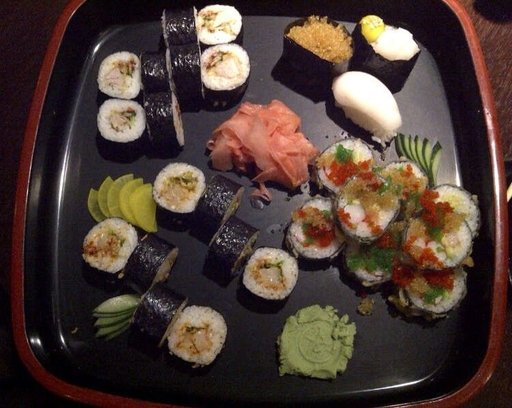

In [77]:
import random
from PIL import Image

# set seed

random.seed(42)

# get all image path

image_path_list = list(image_path.glob("*/*/*.jpg"))

# pick random image path

random_image_path = random.choice(image_path_list)

random_image_path

# get image class from path name

image_class = random_image_path.parent.stem
image_class

# open image

img = Image.open(random_image_path)

# print metadata

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image dimensions: {img.height} x {img.width}")
img

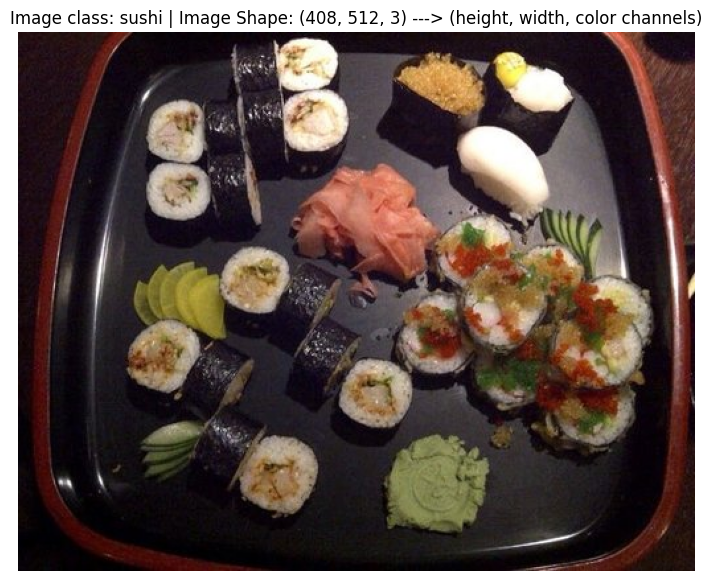

In [78]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image Shape: {img_as_array.shape} ---> (height, width, color channels)")
plt.axis(False);

In [79]:
img_as_array

array([[[33, 13, 15],
        [30, 10, 12],
        [30, 10, 12],
        ...,
        [23, 14, 19],
        [21, 12, 17],
        [20, 11, 16]],

       [[35, 15, 17],
        [32, 12, 14],
        [31, 11, 13],
        ...,
        [21, 12, 17],
        [19, 10, 15],
        [19, 10, 15]],

       [[34, 15, 17],
        [31, 12, 14],
        [30, 11, 13],
        ...,
        [19,  9, 17],
        [18,  8, 16],
        [18,  8, 16]],

       ...,

       [[11,  6, 12],
        [11,  6, 12],
        [11,  6, 12],
        ...,
        [33, 19, 18],
        [33, 19, 19],
        [31, 17, 17]],

       [[ 8,  3,  9],
        [ 9,  4, 10],
        [ 9,  4, 10],
        ...,
        [36, 21, 18],
        [32, 16, 16],
        [27, 11, 11]],

       [[ 4,  0,  5],
        [ 5,  0,  6],
        [ 6,  1,  7],
        ...,
        [36, 21, 18],
        [32, 16, 16],
        [25,  9,  9]]], dtype=uint8)

## 3 Transforming data

Before we can use our image data for PyTorch:
1. Turn your target data into tensors.
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.util.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [80]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms


### 3.1 Transforming data with `torchvision.transforms`

In [81]:
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size = (64,64)),
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [82]:
data_transform(img).dtype

torch.float32

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your image ready to be used with a model / perform data augementation.

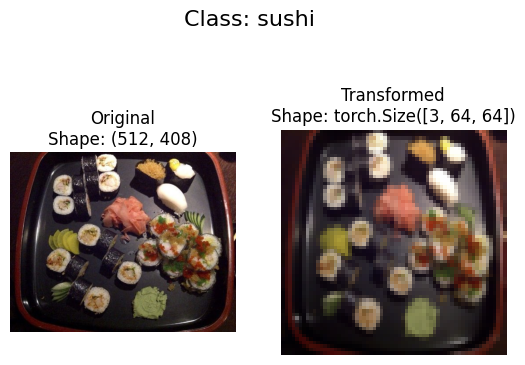

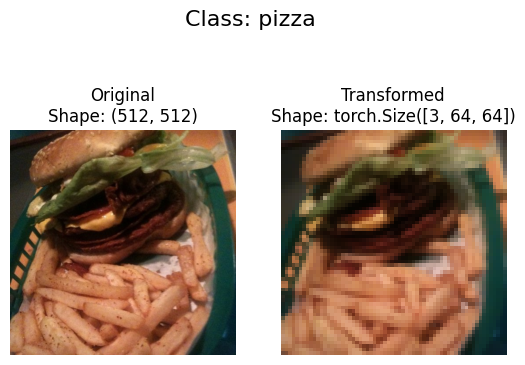

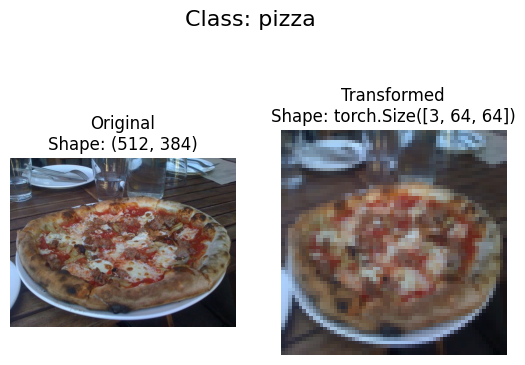

In [83]:
def plot_tranformed_images(image_paths, transform, n = 3 , seed = 42):
    """
    Selects random images from a path of images and loads/transorms 
    them then plots the original vs transformed version.
    """

    if seed:
        random.seed(seed)

    random_image_path = random.sample(image_paths, k = n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig,ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nShape: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f) # We need to change shape for matplotlib
            ax[1].imshow(transformed_image.permute(1,2,0))
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_tranformed_images(image_paths= image_path_list,
                       transform= data_transform,
                       n=3,
                       seed=42)

## 4. Option 1: Loading image data using ImageFolder

we can load image classification data using `torchvision.datasets.ImageFolder` -

In [84]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform= None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform= data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [85]:
# Get class names as list

class_names = train_data.classes

class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [86]:
len(train_data), len(test_data)

(225, 75)

In [87]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [88]:
img , label = train_data[0]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64])
Image permute: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

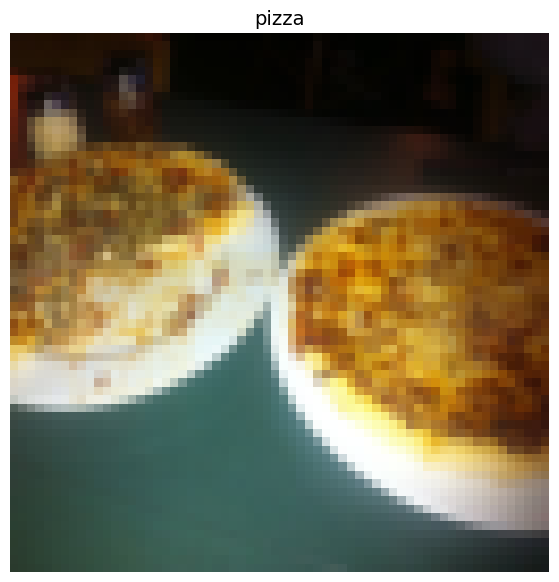

In [89]:
# rearrange order of diemensions
img_permute = img.permute(1,2,0)

# printout different shapes
print(f"Original shape: {img.shape}")
print(f"Image permute: {img_permute.shape}")

# plot 
plt.figure(figsize= (10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize = 14)

### 4.1 Turn loaded images into `DataLoader`'set

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize the `batch_size`, so our model can see `batch_size` images at a time.

In [90]:
!nvidia-smi

Mon Oct 28 01:57:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8              6W /   80W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [91]:
# turn train and test datasets into DataLoader's

from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset= train_data,
                              batch_size= BATCH_SIZE,
                              num_workers= os.cpu_count(),
                              shuffle= True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = os.cpu_count(),
                             shuffle= False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x22898333c40>,
 <torch.utils.data.dataloader.DataLoader at 0x22898333c10>)

In [92]:
len(train_dataloader), len(test_dataloader)


(8, 3)

In [93]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you chan change batchsize if you want

print(f"Image Shape: {img.shape}")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([32, 3, 64, 64])
Label Shape: torch.Size([32])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

We'll start by importing the modules we need:
* Python's `os` for dealing with directories (our data is stored in directories).
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
* `torch` for all things PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add type hints to our code.

> **Note:** You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

In [94]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

Let's see a small example of step 1 before we write the full function.

In [95]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
    """Find the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error is class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
    
    # 3. Create a directory of index labels (computers prefers numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx
    

In [96]:
target_dir = train_dir
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder` 

To Create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (dir to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * Paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset.
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [97]:
# write a custom dataset class

from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, 
                 targ_dir: str, 
                 transform=None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        # setup tranform
        self.transform = transform

        # Create classes and class_to_idx attributes
        self.classes , self.class_to_idx = find_classes(targ_dir)
        
    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it."""

        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """Returns the total number of samples."""

        return len(self.paths)
    

    # 6. Overwrite the __getite; intm__() *mandatory*
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        """Returns 1 sample of data, data and label (X, y)."""

        img = self.load_image(index)

        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_names/image.jpg
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx # return image , label
        else:
            return img, class_idx # return untransformed image, label

In [98]:
# Create tranforms for train and test

train_transform = transforms.Compose([
                                        transforms.Resize(size=(64,64)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor()

])

test_transform = transforms.Compose([
                                        transforms.Resize(size=(64,64)),
                                        transforms.ToTensor()

])

In [99]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform= train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=train_transform)

In [100]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x22898332d70>,
 <__main__.ImageFolderCustom at 0x22898332aa0>)

In [101]:
len(train_data), len(train_data_custom)

(225, 225)

In [102]:
len(test_data), len(test_data_custom)

(75, 75)

In [103]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [104]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [105]:
# check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset.

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib.
7. Makes sure dimension of images line up with matplotlib(HWC)

In [106]:
# 1. Create a function to take in a adataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int= None):
    # 2. adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"for diplay purposes n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k = n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image , targ_label = dataset[targ_sample][0] , dataset[targ_sample][1]

        # 7. change dimensions of tensor for matplotlib (HWC)
        targ_image_adjust = targ_image.permute(1,2,0) # (CHW) -> (HWC)

        # plot adjusted samples

        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Classes: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)

    

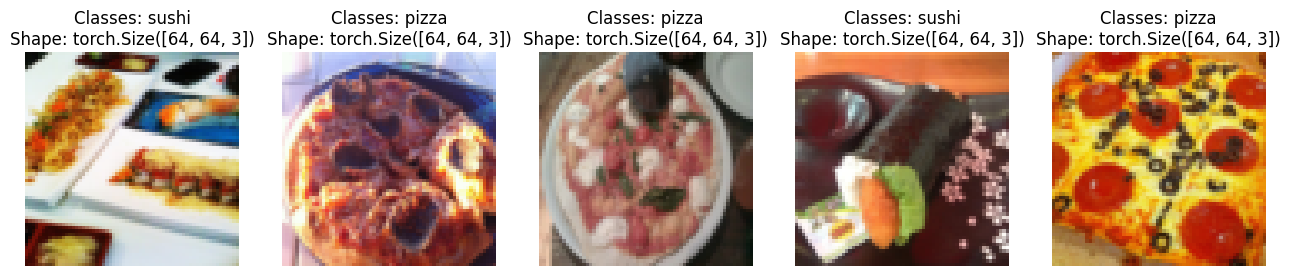

In [107]:
display_random_images(dataset=train_data,
                      classes=train_data.classes,n = 5,seed = 42)

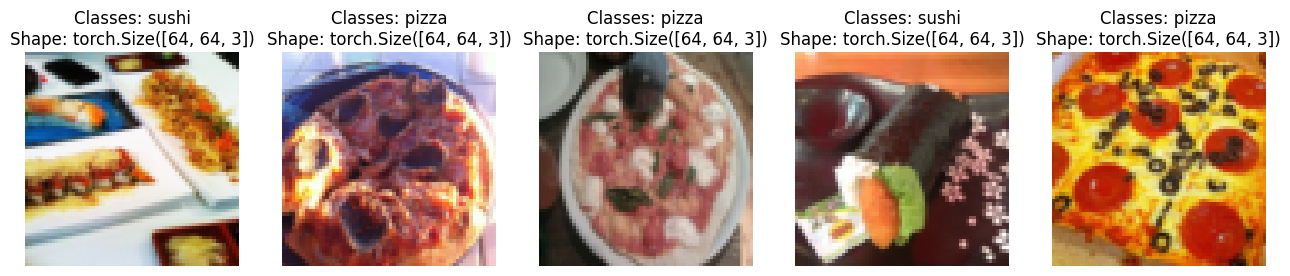

In [108]:
# display random images from imagefoldercustom
display_random_images(dataset=train_data_custom,
                      classes=train_data_custom.classes,n = 5,seed = 42)

### 5.4 Turn Custom Loaded Images into `DataLoader`'s

In [136]:
# turn train and test datasets into DataLoader's

from torch.utils.data import DataLoader
# add this import
# from joblib.externals.loky.backend.context import get_context
# from tqdm.auto import tqdm

BATCH_SIZE = 32
CPU_COUNT = os.cpu_count()    # this now can be > 0

# add multiprocessing_context in DataLoader
train_dataloader_custom = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=CPU_COUNT,
    # multiprocessing_context=get_context('loky') # ADD THIS LINE
)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                             batch_size = BATCH_SIZE,
                             num_workers=CPU_COUNT,
                            #  multiprocessing_context=get_context('loky'), # ADD THIS LINE, (from github to solve exited pid something something issue)
                             shuffle= False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x228980563e0>,
 <torch.utils.data.dataloader.DataLoader at 0x22898333c10>)

In [137]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out the shape

img_custom.shape, label_custom.shape




(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of Tranforms (Data Augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully improves our model for more general unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [138]:
# Lets look at trivial augment 

from torchvision import transforms
train_transform = transforms.Compose([
                                        transforms.Resize(size=(224,224)),
                                        transforms.TrivialAugmentWide(),
                                        transforms.ToTensor()
])

test_transform = transforms.Compose([
                                        transforms.Resize(size = (224, 224)),
                                        transforms.ToTensor()


])

In [139]:
# get all image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

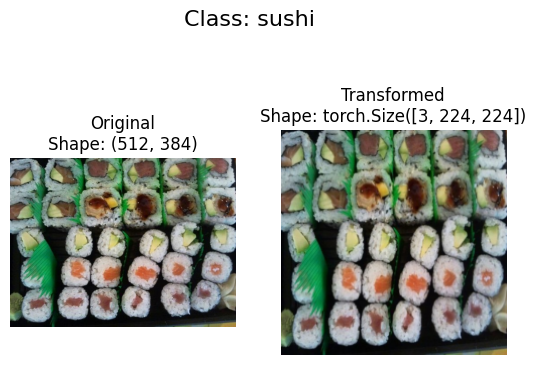

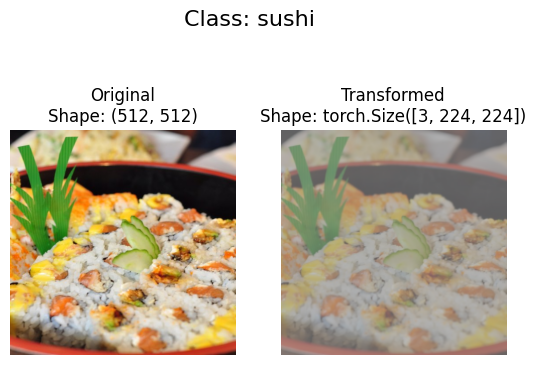

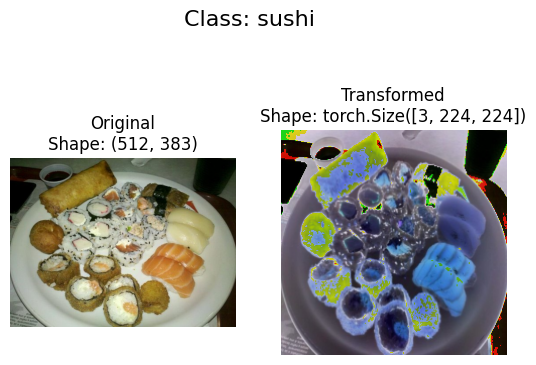

In [144]:
#plot random transformed images

plot_tranformed_images(image_path_list, transform= train_transform, n = 3 , seed = None)